<a href="https://colab.research.google.com/github/yej117/Cloud_Segmentation_Deep_Learning/blob/main/Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
**Topic**: Image Segmentation <br>
**Details**: This project managed to finish the task of image segmentation on the Kaggle: [Carvana Image Masking Challenge](https://www.kaggle.com/c/carvana-image-masking-challenge/). The idea comes from the interests of knowing how to segment the object from the image. The datasets from the Carvana Image Masking Challenge based on high quality car photos and the backgrounds of the images usually ontain similar colors as cars. <br>
**Goals**: Work through the challenge and get to understand how image segmentation works, to know what are the state-or-art methods using for image segmentation, and to fine tune the image segmentation method with the knowledge we have learned from the course.

## Dataset
This project used the dataset from kaggle challenge: [Carvana Image Masking Challenge](https://www.kaggle.com/c/carvana-image-masking-challenge/). 
The dataset contains a large number of car images (as .jpg files). Each car has exactly 16 images, each one taken at different angles. 

The dataset provided by the challenge was separated into different folders and files as the following table (information from the kaggle challenge website)

> **Table 1**: Dataset information

|  file or folders | descriptions |
| -------------| ------------------ |
| train/ | the training dataset images |
| test/ | the test dataset images - the challenge is to predict the mask for each of the image inside |
| train_masks/ | the training set masks in *.gif format |
| train_masks.csv | run-length encoded version of the training set masks |
| sample_submission.csv | show the correct submission format |
| metadata.csv | basic information of about all the cars in the dataset. Note that some values are missing |

As there is no provided mask for the test dataset (which means that we cannot test the performance of our trained model), this project used the train dataset (`train/` and `train_masks/`) and splitted them into training, validation and test datasets.

## U-Net


# Load the dataset from Google Drive

 Mount your Google Drive to the kernel.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/DL_project/kaggle/data/

/content/drive/.shortcut-targets-by-id/1RpWol6vm8TFuJ9p0mkSUtbZHKsT3GtOy/DL_project/kaggle/data


Unzip the data in need.

In [ ]:
#!unzip train.zip
#!unzip train_masks.zip

train	  train_hq.zip	train_masks.csv      train_masks.zip
train_hq  train_masks	train_masks.csv.zip  train.zip


# Data preprocessing

In [3]:
import os

# Directory with our training car pictures
train_car_dir = os.path.join('/content/drive/MyDrive/DL_project/kaggle/data/train')

# Directory with our training mask pictures
train_mask_dir = os.path.join('/content/drive/MyDrive/DL_project/kaggle/data/train_masks')

In [4]:
# read the filenames of train car and its mask, use "sorted" to have the same order
train_car_names = sorted(os.listdir(train_car_dir))
print(train_car_names[:10])

train_mask_names = sorted(os.listdir(train_mask_dir))
print(train_mask_names[:10])

['00087a6bd4dc_01.jpg', '00087a6bd4dc_02.jpg', '00087a6bd4dc_03.jpg', '00087a6bd4dc_04.jpg', '00087a6bd4dc_05.jpg', '00087a6bd4dc_06.jpg', '00087a6bd4dc_07.jpg', '00087a6bd4dc_08.jpg', '00087a6bd4dc_09.jpg', '00087a6bd4dc_10.jpg']
['00087a6bd4dc_01_mask.gif', '00087a6bd4dc_02_mask.gif', '00087a6bd4dc_03_mask.gif', '00087a6bd4dc_04_mask.gif', '00087a6bd4dc_05_mask.gif', '00087a6bd4dc_06_mask.gif', '00087a6bd4dc_07_mask.gif', '00087a6bd4dc_08_mask.gif', '00087a6bd4dc_09_mask.gif', '00087a6bd4dc_10_mask.gif']


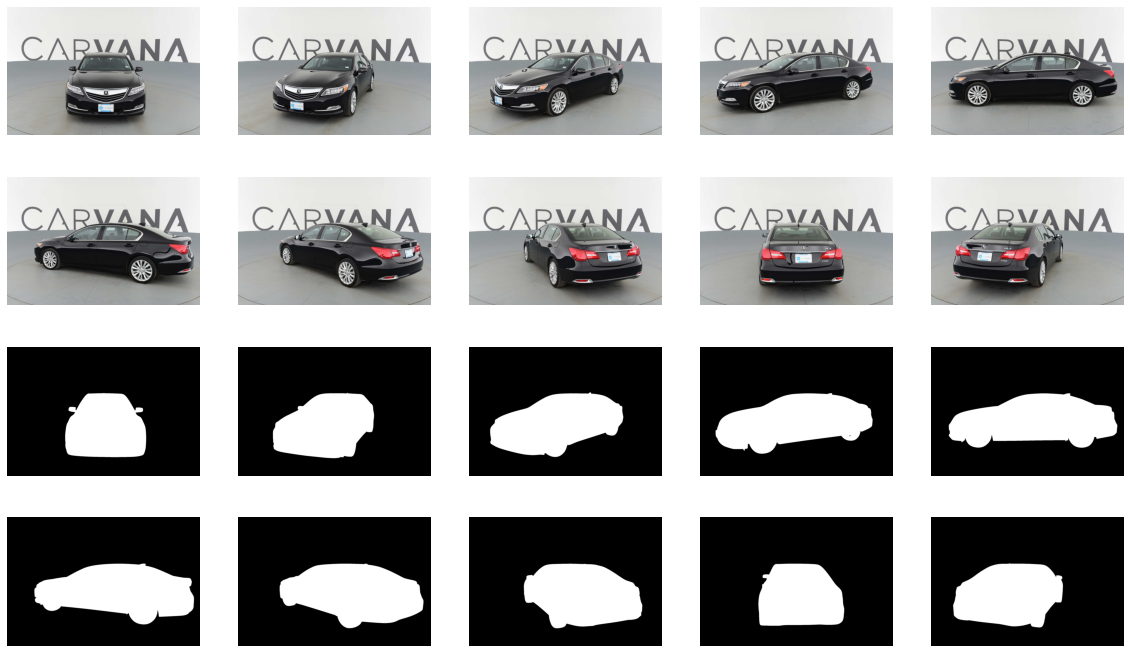

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 5

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)
pic_index = 0
#pic_index += 1
next_car_pix = [os.path.join(train_car_dir, fname) 
                for fname in train_car_names[pic_index:pic_index+10]]
next_mask_pix = [os.path.join(train_mask_dir, fname) 
                for fname in train_mask_names[pic_index:pic_index+10]]

preview_index = 10
for i, img_path in enumerate(next_car_pix+next_mask_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Image Augmentation

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

Load data to numpy array and resize it... (too powerful...)

In [7]:
def load_data(car_list, mask_list, img_size):
  img_car = []
  img_mask = []
  # Load and resize the images
  for car, mask in zip(car_list, mask_list):
    #img_car.append(cv2.resize(cv2.imread(car), img_size)/255)
    img_car.append(img_to_array(
                    load_img(car, target_size=(256,256))
                    )/255)
    #img_mask.append(cv2.resize(plt.imread(mask), img_size)/255)
    img_mask.append(np.average(img_to_array(load_img(mask, target_size=(256,256)))/255, axis=-1 ))
    
  # Split dataset into training (70%) and validation (30 %)                             
  x_train, x_val, y_train, y_val = train_test_split(img_car, img_mask,
                                                    test_size=0.3,
                                                    random_state=0)
  # Then split validation dataset into validation (20 %) and testing (10 %)
  x_val, x_test, y_val, y_test = train_test_split(x_val, y_val,
                                                  test_size=(1/3),
                                                  random_state=0)
  x_train = np.array(x_train)
  x_test = np.array(x_test)
  x_val = np.array(x_val)
    
  return x_train, x_val, x_test, y_train, y_val, y_test

In [8]:
car_pix = [os.path.join(train_car_dir, fname) 
           for fname in train_car_names[:]]
mask_pix = [os.path.join(train_mask_dir, fname) 
            for fname in train_mask_names[:]]

x_train, x_val, x_test, y_train, y_val, y_test = load_data(car_pix, mask_pix, (256, 256))


print("Training dataset: %i"%(len(x_train)))
print("Validation dataset: %i"%(len(x_val)))
print("Test dataset: %i"%(len(x_test)))

Training dataset: 839
Validation dataset: 240
Test dataset: 120


Check the...

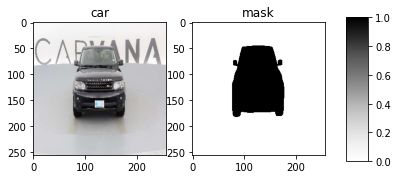

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(x_train[0])
axes[0].set_title('car')
im = axes[1].imshow(y_train[0], cmap = plt.cm.Greys)
    
axes[1].set_title('mask')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.05, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
plt.show()


Image Augmentation

In [10]:
batch_size = 32
gen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

gen_flow = gen.flow(x_train, y_train, batch_size = batch_size)

val_gen = ImageDataGenerator()
val_gen_flow = val_gen.flow(x_val, y_val, batch_size = batch_size)


# Building model

https://medium.com/datadriveninvestor/an-overview-on-u-net-architecture-d6caabf7caa4

In [17]:
from keras.models import Model
from keras.layers import Conv2D, Input, MaxPooling2D, concatenate, Conv2DTranspose

In [18]:
def create_unet():
  input_img = Input(shape=(256, 256, 3), name="X_img")

  # down
  # cnn 3x3 + ReLU 
  c1 = Conv2D(16, kernel_size=(3,3), activation = "relu", padding='same')(input_img)
  c1 = Conv2D(16, kernel_size=(3,3), activation = "relu", padding='same')(c1)
  
  # max. pooling 2x2
  p1 = MaxPooling2D((2,2))(c1)

  # cnn 3x3 + ReLU 
  c2 = Conv2D(32, kernel_size=(3,3), activation = "relu", padding='same')(p1)
  c2 = Conv2D(32, kernel_size=(3,3), activation = "relu", padding='same')(c2)
  # max. pooling 2x2
  p2 = MaxPooling2D((2,2))(c2)

  #
  # cnn 3x3 + ReLU 
  c3 = Conv2D(64, kernel_size=(3,3), activation = "relu", padding='same')(p2)
  c3 = Conv2D(64, kernel_size=(3,3), activation = "relu", padding='same')(c3)
  # max. pooling 2x2
  p3 = MaxPooling2D((2,2))(c3)

  # cnn 3x3 + ReLU 
  c4 = Conv2D(128, kernel_size=(3,3), activation = "relu", padding='same')(p3)
  c4 = Conv2D(128, kernel_size=(3,3), activation = "relu", padding='same')(c4)
  # max. pooling 2x2
  p4 = MaxPooling2D((2,2))(c4)

  # cnn 3x3 + ReLU 
  c5 = Conv2D(256, kernel_size=(3,3), activation = "relu", padding='same')(p4)
  c5 = Conv2D(256, kernel_size=(3,3), activation = "relu", padding='same')(c5)
  
  # up
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2)) (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation = "relu", padding='same')(u6)
  c6 = Conv2D(128, (3, 3), activation = "relu", padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2)) (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation = "relu", padding='same')(u7)
  c7 = Conv2D(64, (3, 3), activation = "relu", padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2)) (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation = "relu", padding='same')(u8)
  c8 = Conv2D(32, (3, 3), activation = "relu", padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2)) (c8)
  u9 = concatenate([u9, c1])
  c9 = Conv2D(16, (3, 3), activation = "relu", padding='same')(u9)
  c9 = Conv2D(16, (3, 3), activation = "relu", padding='same') (c9)

  # output
  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[input_img], outputs=[outputs])
  model.compile(optimizer='adam',loss='binary_crossentropy', metrics=["accuracy"])#  metrics=[iou_loss_score]
  model.summary()
  return model

In [19]:
model=create_unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_img (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 256, 16) 448         X_img[0][0]                      
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_12[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_13[0][0]                  
______________________________________________________________________________________________

In [33]:
history = model.fit(gen_flow, validation_data = val_gen_flow, steps_per_epoch=len(x_train) / batch_size, epochs=10, batch_size = batch_size)

Epoch 1/10
26/26 [==============================] - 568s 22s/step - loss: 0.5471 - accuracy: 0.7936 - val_loss: 0.4341 - val_accuracy: 0.7920
Epoch 2/10
26/26 [==============================] - 566s 22s/step - loss: 0.4688 - accuracy: 0.7948 - val_loss: 0.4194 - val_accuracy: 0.8460
Epoch 3/10
26/26 [==============================] - 559s 21s/step - loss: 0.4571 - accuracy: 0.7918 - val_loss: 0.4133 - val_accuracy: 0.8553
Epoch 4/10
26/26 [==============================] - 556s 21s/step - loss: 0.4077 - accuracy: 0.7989 - val_loss: 0.2948 - val_accuracy: 0.8426
Epoch 5/10
26/26 [==============================] - 561s 21s/step - loss: 0.3074 - accuracy: 0.8325 - val_loss: 0.2598 - val_accuracy: 0.8818
Epoch 6/10
26/26 [==============================] - 557s 21s/step - loss: 0.2658 - accuracy: 0.8813 - val_loss: 0.2574 - val_accuracy: 0.8915
Epoch 7/10
26/26 [==============================] - 558s 21s/step - loss: 0.2649 - accuracy: 0.8861 - val_loss: 0.2421 - val_accuracy: 0.8948
Epoch 

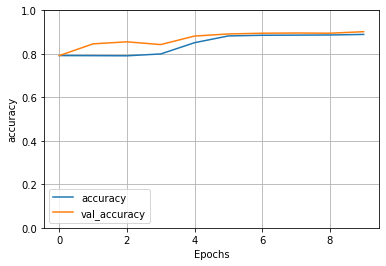

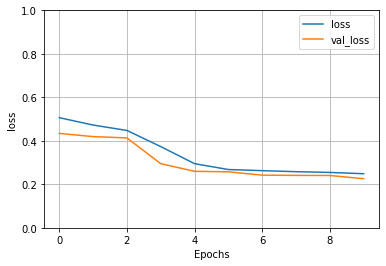

In [39]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string], loc = 'best')
  plt.ylim([0,1])
  plt.grid()
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [35]:
test_gen = ImageDataGenerator()
test_gen_flow = test_gen.flow(x_test, y_test, batch_size = batch_size)
results = model.evaluate(test_gen_flow)

4/4 [==============================] - 18s 4s/step - loss: 0.2338 - accuracy: 0.8976


In [41]:
model.save("model_unet.hd5")

INFO:tensorflow:Assets written to: model_unet.hd5/assets
